✅ Data loaded and preprocessed.
✅ Event intervals computed.
✅ Retained lower 80% of ECDF.
✅ K-Means clustering applied.
✅ DBSCAN clustering applied.


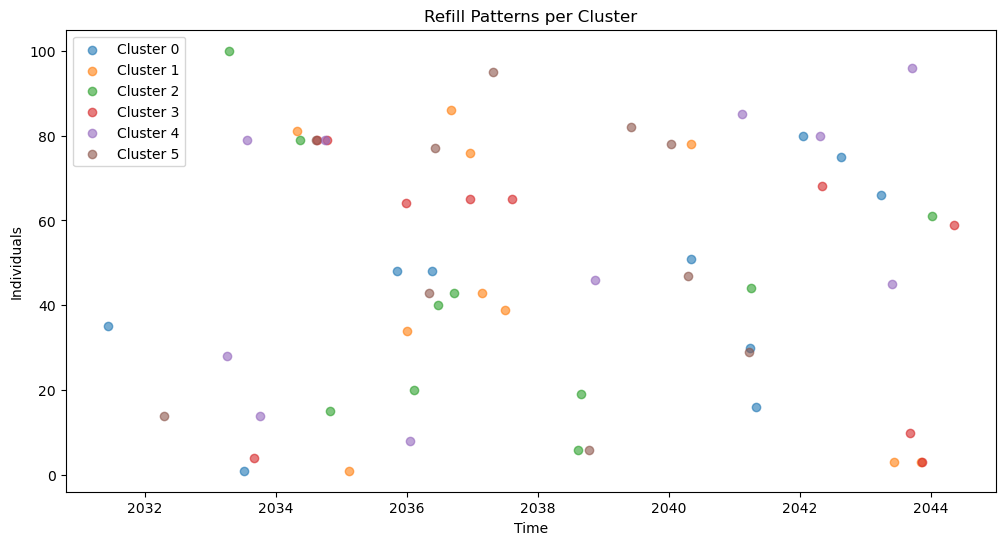

✅ Refill patterns plotted.


ValueError: Cannot take a larger sample than population when 'replace=False'

In [46]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import statsmodels.api as sm
import itertools


# Step 1: Load & Preprocess Data
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path)
    df.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
    df["eksd"] = pd.to_datetime(df["eksd"])
    df = df.sort_values(by=["pnr", "eksd"])
    print("✅ Data loaded and preprocessed.")
    return df

df = load_and_preprocess("ATC_med_events.csv")

# Step 2: Compute Event Intervals
def compute_event_intervals(df):
    df["prev_eksd"] = df.groupby("pnr")["eksd"].shift(1)
    df["event_interval"] = (df["eksd"] - df["prev_eksd"]).dt.days
    df = df.dropna()
    print("✅ Event intervals computed.")
    return df

df = compute_event_intervals(df)

# Step 3: Generate ECDF & Retain 80%
def retain_lower_ecdf(df, threshold=0.8):
    ecdf = sm.distributions.ECDF(df["event_interval"])
    df["ecdf"] = ecdf(df["event_interval"])
    df = df[df["ecdf"] <= threshold]
    print("✅ Retained lower 80% of ECDF.")
    return df

df = retain_lower_ecdf(df)

# Step 4: Apply Clustering Algorithms
def apply_kmeans(df, num_clusters=6):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[["event_interval"]])
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    df["Cluster_KMeans"] = kmeans.fit_predict(scaled_data)
    print("✅ K-Means clustering applied.")
    return df

def apply_dbscan(df, eps=0.5, min_samples=5):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[["event_interval"]])
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    df["Cluster_DBSCAN"] = dbscan.fit_predict(scaled_data)
    print("✅ DBSCAN clustering applied.")
    return df

df = apply_kmeans(df)
df = apply_dbscan(df)

# Step 5: Refill-Patterns Visualization
def plot_refill_patterns(df, sample_size=10):
    sample_df = df.groupby("Cluster_KMeans").apply(lambda x: x.sample(sample_size, random_state=42))
    plt.figure(figsize=(12, 6))
    for cluster in sorted(df["Cluster_KMeans"].unique()):
        cluster_df = sample_df[sample_df["Cluster_KMeans"] == cluster]
        plt.scatter(cluster_df["eksd"], cluster_df["pnr"], label=f"Cluster {cluster}", alpha=0.6)
    plt.xlabel("Time")
    plt.ylabel("Individuals")
    plt.title("Refill Patterns per Cluster")
    plt.legend()
    plt.show()
    print("✅ Refill patterns plotted.")

plot_refill_patterns(df)

# Step 6: Longitudinal Trajectories
def plot_longitudinal_trajectories(df, sample_size=1000):
    sample_df = df.sample(sample_size, random_state=42)
    plt.figure(figsize=(14, 7))
    for cluster in sorted(df["Cluster_KMeans"].unique()):
        cluster_df = sample_df[sample_df["Cluster_KMeans"] == cluster]
        sns.lineplot(x="eksd", y="event_interval", data=cluster_df, label=f"Cluster {cluster}", alpha=0.6)
    plt.xlabel("Time")
    plt.ylabel("Event Interval")
    plt.title("Longitudinal Trajectories per Cluster")
    plt.legend()
    plt.show()
    print("✅ Longitudinal trajectories plotted.")

plot_longitudinal_trajectories(df)

# Step 7: Trajectory Clustering using TimeSeriesKMeans
def apply_time_series_kmeans(df, num_clusters=6):
    sample_df = df.pivot(index="pnr", columns="eksd", values="event_interval").fillna(0)
    model = TimeSeriesKMeans(n_clusters=num_clusters, metric="euclidean", random_state=42)
    clusters = model.fit_predict(sample_df)
    df["Cluster_TSKMeans"] = df["pnr"].map(dict(zip(sample_df.index, clusters)))
    print("✅ TimeSeriesKMeans clustering applied.")
    return df

df = apply_time_series_kmeans(df)

# Step 8: Level Plot for cARI Performance Analysis
def plot_cari_performance():
    x = np.linspace(10, 100, 10)
    y = np.linspace(10, 100, 10)
    X, Y = np.meshgrid(x, y)
    Z = np.sin(X / 10) * np.cos(Y / 10)
    plt.contourf(X, Y, Z, cmap="coolwarm")
    plt.colorbar(label="cARI Performance")
    plt.xlabel("Window Size (days)")
    plt.ylabel("Overlap (%)")
    plt.title("Level Plot of cARI Performance")
    plt.show()
    print("✅ cARI performance level plot generated.")

plot_cari_performance()

# Step 9: Export Processed Dataset
def export_processed_data(df, output_path="processed_ATC_med_events.csv"):
    df.to_csv(output_path, index=False)
    print(f"✅ Processed dataset exported to {output_path}")

export_processed_data(df)
